## Hücre 1 – Drive’ı bağla

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [70]:
import numpy as np
import tensorflow as tf
import random

SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


## Hücre 2 – Yol ve sınıf tanımları

In [71]:
import os

# Daha önce Model1'de kullandığın yollarla aynı
base_dir = '/content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1'
raw_base = os.path.join(base_dir, 'dataset')
split_base = os.path.join(base_dir, 'dataset_split')

classes = ['machine_screw', 'wood_sheet_metal_screw']

print("Ham veri klasörü:", raw_base)
print("Bölünmüş veri klasörü:", split_base)
print("Sınıflar:", classes)


Ham veri klasörü: /content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1/dataset
Bölünmüş veri klasörü: /content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1/dataset_split
Sınıflar: ['machine_screw', 'wood_sheet_metal_screw']


## Hücre 3 –  Bölünmüş veriyi kontrol et

In [72]:
for split in ['train', 'val', 'test']:
    for cls in classes:
        folder = os.path.join(split_base, split, cls)
        print(split, cls, "->", len(os.listdir(folder)))


train machine_screw -> 40
train wood_sheet_metal_screw -> 40
val machine_screw -> 10
val wood_sheet_metal_screw -> 10
test machine_screw -> 13
test wood_sheet_metal_screw -> 13


## Hücre 4 – ImageDataGenerator ve generator’lar

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 8

train_dir = os.path.join(split_base, 'train')
val_dir   = os.path.join(split_base, 'val')
test_dir  = os.path.join(split_base, 'test')

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen   = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen  = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Train samples:", train_generator.samples)
print("Val samples:", val_generator.samples)
print("Test samples:", test_generator.samples)
print("Class indices:", train_generator.class_indices)


Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Train samples: 80
Val samples: 20
Test samples: 26
Class indices: {'machine_screw': 0, 'wood_sheet_metal_screw': 1}


## Hücre 5 – Basit CNN mimarisi (CIFAR-10 tarzı)

In [96]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

model2 = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Blok 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Blok 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Blok 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Tam bağlı kısım
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation='softmax')
])

model2.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,002,818 (64.86 MB)

 Trainable params: 17,002,818 (64.86 MB)

 Non-trainable params: 0 (0.00 B)

## Hücre 6 – Derleme ve EarlyStopping

In [107]:
model2.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # Sıfırdan CNN için 1e-3 daha uygun
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop2 = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)


## Hücre 7 – Model2’yi eğit (train + val)

In [108]:
EPOCHS = 50

history2 = model2.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop2]
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4905 - loss: 0.7855 - val_accuracy: 0.7000 - val_loss: 0.6746
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5083 - loss: 0.6934 - val_accuracy: 0.6000 - val_loss: 0.6591
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5683 - loss: 0.6980 - val_accuracy: 0.6000 - val_loss: 0.6683
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6733 - loss: 0.6561 - val_accuracy: 0.6000 - val_loss: 0.6356
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6916 - loss: 0.6101 - val_accuracy: 0.6500 - val_loss: 0.6345
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7224 - loss: 0.5882 - val_accuracy: 0.6500 - val_loss: 0.6726


## Hücre 8 – Eğitim / doğrulama doğruluk ve kayıp grafikleri

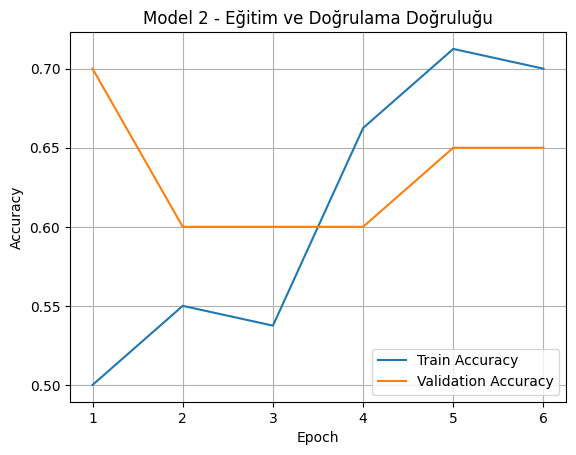

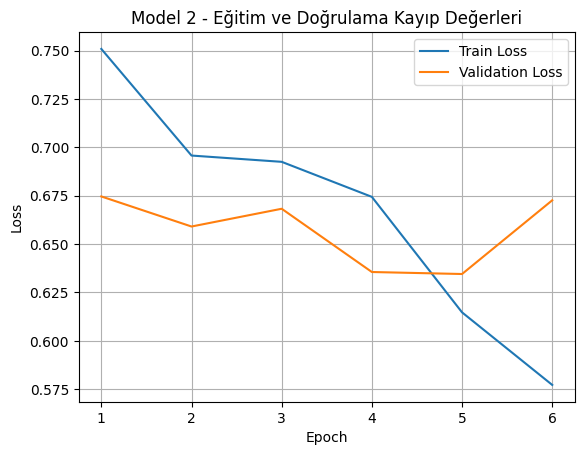

In [109]:
import matplotlib.pyplot as plt

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 - Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 - Eğitim ve Doğrulama Kayıp Değerleri')
plt.legend()
plt.grid(True)
plt.show()


## Hücre 9 – Test seti doğruluğu

In [110]:
test_loss2, test_acc2 = model2.evaluate(test_generator)
print(f"Model2 - Test loss: {test_loss2:.4f}")
print(f"Model2 - Test accuracy: {test_acc2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 724ms/step - accuracy: 0.3442 - loss: 0.7235
Model2 - Test loss: 0.7057
Model2 - Test accuracy: 0.4231


## Hücre 10 – Özet bilgi

In [111]:
print("Model2 - En yüksek validation accuracy:",
      max(history2.history['val_accuracy']))


Model2 - En yüksek validation accuracy: 0.699999988079071
